In [75]:
import sys
import time

import CDPL.Base as Base
import CDPL.Biomol as Biomol
import CDPL.Chem as Chem
import CDPL.Math as Math
import CDPL.Pharm as Pharm
import MDAnalysis
import argparse
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import os
import pandas as pd
import uuid
import math

import pickle
import rdkit.Chem.AllChem as rdChem
import scipy.stats
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rdkit.Chem.Draw import rdMolDraw2D

import networkx as nx
import visJS2jupyter.visJS_module
import copy

In [76]:
def getGlobalPh4InteractionList(ph4_interaction_dictionary):
    global_ph4_interaction_list = []
    global_count = []

    for dict_int in ph4_interaction_dictionary.values():
        list_int_already_counted = []
        for list_int in dict_int.values():
            for tmp_int in list_int:
                if 'HOH' not in tmp_int.env_residue:
                    if sum(tmp_int == x for x in global_ph4_interaction_list) == 0:
                        global_ph4_interaction_list.append(tmp_int)
                        global_count.append(1)
                        list_int_already_counted.append(tmp_int)

                    elif sum(tmp_int == x for x in list_int_already_counted) == 0:
                        global_count[global_ph4_interaction_list.index(tmp_int)] += 1
                        list_int_already_counted.append(tmp_int)

    tmp_list = [(global_ph4_interaction_list[x], global_count[x]) for x in range(len(global_ph4_interaction_list))]
    return sorted(tmp_list, key=lambda k: (k[0].interaction_type, int(k[0].env_residue.split('_')[1])))


def getPh4FingerprintDictionary(ph4_interaction_dictionary, global_ph4_interaction_list):
    tmp_list = [x[0] for x in global_ph4_interaction_list]
    global_ph4_fingerprint_dictionary = defaultdict(lambda:[0 for y in tmp_list])

    for frame_number, dict_int in ph4_interaction_dictionary.items():
        
        print frame_number
        #print dict_int
        for list_int in dict_int.values():
            #print list_int
            for tmp_int in list_int:
                #print tmp_int
                if tmp_int in tmp_list:
                    global_ph4_fingerprint_dictionary[frame_number][tmp_list.index(tmp_int)] = 1
    return global_ph4_fingerprint_dictionary


def getPh4TimeSeries(ph4_fingerprint_dictionary, global_ph4_interaction_list):
    global_ph4_fingerprint_dictionary = {}
    nb_int = len(global_ph4_interaction_list)
    nb_frame = len(ph4_fingerprint_dictionary)

    for i in range(nb_int):
        global_ph4_fingerprint_dictionary[i] = [0]* nb_frame

    for i in range(nb_int):
        for j in range(nb_frame):
            global_ph4_fingerprint_dictionary[i][j] = ph4_fingerprint_dictionary[j][i]

    df = pd.DataFrame.from_dict(global_ph4_fingerprint_dictionary)
    df.columns=[(x[0].interaction_type, x[0].env_residue, str(x[0].env_atom), x[0].lig_residue, str(x[0].lig_atom)) for x in global_ph4_interaction_list]

    return [(global_ph4_interaction_list[x][0], global_ph4_interaction_list[x][1], global_ph4_fingerprint_dictionary[x]) for x in range(nb_int)], df


class Ph4InteractionInformation(object):
    def __init__(self, lig_feature, env_feature):
        ftype_names = {Pharm.FeatureType.H_BOND_ACCEPTOR: 'HBA', Pharm.FeatureType.H_BOND_DONOR: 'HBD',
                       Pharm.FeatureType.POS_IONIZABLE: 'PI', Pharm.FeatureType.NEG_IONIZABLE: 'NI',
                       Pharm.FeatureType.AROMATIC: 'AR', Pharm.FeatureType.HYDROPHOBIC: 'H',
                       Pharm.FeatureType.X_VOLUME: 'XV'}

        lig_feature_type = ftype_names[Pharm.getType(lig_feature)]
        lig_residue_code = Biomol.getResidueCode(Pharm.getSubstructure(lig_feature).atoms[0])
        lig_residue_number = Biomol.getResidueSequenceNumber(Pharm.getSubstructure(lig_feature).atoms[0])
        lig_residue_chain = Biomol.getChainID(Pharm.getSubstructure(lig_feature).atoms[0])

        env_feature_type = ftype_names[Pharm.getType(env_feature)]
        env_residue_code = Biomol.getResidueCode(Pharm.getSubstructure(env_feature).atoms[0])
        env_residue_number = Biomol.getResidueSequenceNumber(Pharm.getSubstructure(env_feature).atoms[0])
        env_residue_chain = Biomol.getChainID(Pharm.getSubstructure(env_feature).atoms[0])

        self.interaction_type = '{}-{}'.format(lig_feature_type, env_feature_type)
        self.lig_residue = '{}_{}_{}'.format(lig_residue_code, lig_residue_number, lig_residue_chain)
        self.env_residue = '{}_{}_{}'.format(env_residue_code, env_residue_number, env_residue_chain)

        atoms = []
        for atom in Pharm.getSubstructure(lig_feature).atoms:
            key_atom = '{}:{}'.format(Chem.getSymbol(atom), Biomol.getSerialNumber(atom))
            atoms.append(key_atom)

        self.lig_atom = sorted(atoms, key=lambda k: int(k.split(':')[1]))

        atoms = []
        for atom in Pharm.getSubstructure(env_feature).atoms:
            key_atom = '{}:{}'.format(Chem.getSymbol(atom), Biomol.getSerialNumber(atom))
            atoms.append(key_atom)

        self.env_atom = sorted(atoms, key=lambda k: int(k.split(':')[1]))

    def __str__(self):
        txt = ''
        for key in sorted(self.__dict__):
            txt += '> {:<20}: {:<20}\n'.format(key, self.__dict__[key])
        return txt

    def __eq__(self, other):
        #return self.__dict__ == other.__dict__
        return (self.interaction_type == other.interaction_type and self.env_residue[:-1] == other.env_residue[:-1])
        #return self.env_residue[:-1] == other.env_residue[:-1]

        #return (self.env_residue == other.env_residue)
        #return (self.lig_residue[:-1] == other.lig_residue[:-1] and self.interaction_type == other.interaction_type and self.lig_atom == other.lig_atom)
     
    def __ne__(self, other):
        return not self.__eq__(other)

    def getInteractionType(self):
        return self.interaction_type

    def getLigand(self):
        return [self.lig_residue, str(self.lig_atom)] if self.lig_atom is not None else [self.lig_residue]

    def getEnvironment(self):
        return [self.env_residue, str(self.env_atom)] if self.env_atom is not None else [self.env_residue]

    
    
class ph4Node(object):
    def __init__(self, fp, frames=None, index=None):
        if index is not None:
            self.index = [index]
        else:
            self.index = []

        self.fingerprint = fp
        self.interaction_count = sum(self.fingerprint)
        if frames is None:
            self.frames = None
            self.appearance = None
        else:
            self.setFrames(frames)
            
        self.children = set()
        self.parents = set()
        
    def setChild(self, child):
        self.children.append(child)
        
    def setParent(self, parent):
        self.parents.append(parent)
        
    def setFrames(self, frames):
        self.frames = frames
        self.setAppearance(len(self.frames))
        
    def setAppearance(self, appearance):
        self.appearance = appearance
        
    def __eq__(self, other):
        return self.fingerprint == other.fingerprint

    def __ne__(self, other):
        return not self.__eq__(other)
    
def getFPAncestor(node_1, node_2):
    fp_1 = node_1.fingerprint
    fp_2 = node_2.fingerprint
    ancestor = tuple([1 if (fp_1[index] == 1 == fp_2[index]) else 0 for index in range(len(fp_1))])
    return ancestor
    #if ancestor != fp_1 and ancestor != fp_2:
    #    return ancestor
    #else:
    #    return None

def getTanimoto(node_1, node_2):
    fp_1 = node_1.fingerprint
    fp_2 = node_2.fingerprint
    union = [1  if (value == 1 or fp_2[index] == 1) else 0 for index, value in enumerate(fp_1)]
    intersect = [1 if (value == 1 == fp_2[index]) else 0 for index, value in enumerate(fp_1)]
    return float(sum(intersect))/float(sum(union))

def isParent(node_1, node_2):
    fp_1 = node_1.fingerprint
    fp_2 = node_2.fingerprint
    return  sum(fp_1) == sum([1 if fp_1[i] == fp_2[i] == 1 else 0 for i in range(len(fp_1))])

def getNodeAncestor(index_node_1, index_node_2, list_nodes):
    fp_ancestor = getFPAncestor(list_nodes[index_node_1], list_nodes[index_node_2])
    return [list_nodes.index(x) for x in list_nodes if x.fingerprint == fp_ancestor][0]

def getFiliation(index, list_nodes):
    filiation = gF(index, list_nodes)
    filiation.remove(list_nodes[index].fingerprint)
    return filiation

def gF(index, list_nodes):
    filiation = set()
    for fp_child in list_nodes[index].children:
        index_child = getIndexPool(fp_child, list_nodes)
        filiation.update(gF(index_child, list_nodes))
    
    filiation.add(list_nodes[index].fingerprint)
    return filiation


def getIndexPool(fp, pool):
    return [i for i,x in enumerate(pool) if x.fingerprint == fp][0]

In [77]:
#Ki(uM)
affinity = {0:151, 1:42,2:180, 3:0.5, 4:5, 5:5, 6:22, 7:22, 8:300, 9:9, 10:38, 11:28, 12:3, 13:3}

In [78]:
pdb_name={0: '3cqu', 1: '3cqw', 2: '3mv5', 3: '3mvh', 4: '3ocb_l1', 5: '3ocb_l2', 6: '3ow4_l1', 7: '3ow4_l2', 8: '3qkk', 9: '3qkl', 10: '3qkm', 11: '4ekl', 12: '4gv1', 13: '6ccy', }

In [81]:
name = '/home/agaron/stunning-octo-computing-machine/data/akt1/'+pdb_name[0]+'_clean.gt'
with open(name, 'r') as handle:
    ph4_interaction_dictionary = pickle.load(handle)

In [82]:
for i in range(1,14):
    name = '/home/agaron/stunning-octo-computing-machine/data/akt1/'+pdb_name[i]+'_clean.gt'
    with open(name, 'r') as handle:
        ph4_interaction_dictionary_pdb = pickle.load(handle)
    ph4_interaction_dictionary[max(ph4_interaction_dictionary.keys())+1] = copy.deepcopy(ph4_interaction_dictionary_pdb[0])   

In [83]:
global_ph4_interaction_list = getGlobalPh4InteractionList(ph4_interaction_dictionary)
print len(global_ph4_interaction_list)
ph4_fingerprint_dict = getPh4FingerprintDictionary(ph4_interaction_dictionary, global_ph4_interaction_list)
ph4_time_series = getPh4TimeSeries(ph4_fingerprint_dict, global_ph4_interaction_list)

35
0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [84]:
for x,y in ph4_interaction_dictionary[0].items():
    print '************'
    print x
    for z in y:
        print z

************
H-H
> env_atom            : ['C:323', 'C:324', 'C:325']
> env_residue         : VAL_164_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5461', 'C:5475', 'C:5476', 'N:5477', 'C:5478']
> lig_residue         : CQU_999_A           

> env_atom            : ['C:546', 'C:549']  
> env_residue         : ALA_177_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5461', 'C:5475', 'C:5476', 'N:5477', 'C:5478']
> lig_residue         : CQU_999_A           

> env_atom            : ['C:1476', 'C:1479']
> env_residue         : ALA_230_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5461', 'C:5475', 'C:5476', 'N:5477', 'C:5478']
> lig_residue         : CQU_999_A           

> env_atom            : ['C:1429']          
> env_residue         : MET_227_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5461', 'C:5475', 'C:5476', 'N:5477', 'C:5478'

In [85]:
counts = dict()
for index, value in enumerate([tuple(x) for x in ph4_fingerprint_dict.values()]):
    if value in counts.keys():
        counts[value].append(index)
    else:
        counts[value] = [index]

In [86]:
tmp_fp = [(x,y) for x,y in counts.items() if len(y)>0 or x == tuple(ph4_fingerprint_dict[max(ph4_fingerprint_dict.keys())])]
len(tmp_fp)

14

In [87]:
pool = sorted([ph4Node(x[0], x[1]) for x in tmp_fp], key=lambda k: k.interaction_count, reverse=True)

In [88]:
main_pool = []
current_pool = copy.deepcopy(pool)

while len(current_pool)>0:
    current_node = current_pool[0]
    current_pool.pop(0)

    for node_pool in current_pool:
        fp_ancestor = getFPAncestor(current_node, node_pool) 
        if fp_ancestor != current_node.fingerprint and fp_ancestor != node_pool.fingerprint:
            if fp_ancestor in [x.fingerprint for x in main_pool]:
                node_ancestor = [x for x in main_pool if x.fingerprint == fp_ancestor][0]
                main_pool[main_pool.index(node_ancestor)].children.add(current_node.fingerprint)
                main_pool[main_pool.index(node_ancestor)].children.add(node_pool.fingerprint)
            else:
                if fp_ancestor not in [x.fingerprint for x in current_pool]:
                    current_pool.append(ph4Node(fp_ancestor))

                node_ancestor = [x for x in current_pool if x.fingerprint == fp_ancestor][0] 
                current_pool[current_pool.index(node_ancestor)].children.add(current_node.fingerprint)
                current_pool[current_pool.index(node_ancestor)].children.add(node_pool.fingerprint)
                
            current_node.parents.add(fp_ancestor)
            node_pool.parents.add(fp_ancestor)
            
        elif fp_ancestor == current_node.fingerprint:
            current_node.children.add(node_pool.fingerprint)
            node_pool.parents.add(fp_ancestor)
        elif fp_ancestor == node_pool.fingerprint:
            node_pool.children.add(current_node.fingerprint)
            current_node.parents.add(fp_ancestor)
        else:
            print "> Already there"

            
            
    main_pool.append(current_node)
    
print('> Main_pool: {}'.format(len(main_pool)))

> Main_pool: 72


In [24]:
main_pool = []
current_pool = copy.deepcopy(pool)

while len(current_pool)>0:
    print len(current_pool)
    current_node = current_pool[0]
    current_pool.pop(0)

    for node_pool in current_pool:
        fp_ancestor = getFPAncestor(current_node, node_pool) 
            
        if fp_ancestor == current_node.fingerprint:
            current_node.children.add(node_pool.fingerprint)
            node_pool.parents.add(fp_ancestor)
        if fp_ancestor == node_pool.fingerprint:
            node_pool.children.add(current_node.fingerprint)
            current_node.parents.add(fp_ancestor)
        else:
            print "> Already there"

            
            
    main_pool.append(current_node)
    


5
> Already there
> Already there
> Already there
> Already there
4
> Already there
> Already there
> Already there
3
> Already there
> Already there
2
> Already there
1


In [89]:
filiation_list = {}
for node in sorted(main_pool, key=lambda k: k.interaction_count, reverse=True):
    print
    print main_pool.index(node)
    print len(main_pool[main_pool.index(node)].children)
    
    current_children = sorted(node.children, key=lambda k: sum(k))
    new_children = copy.deepcopy(current_children)
    
    while len(current_children) > 0:
        current_child = current_children[0]
        current_children.pop(0)
        index_current_child = getIndexPool(current_child, main_pool)
        filiation = getFiliation(index_current_child, main_pool)
        for child in current_children:
            if child in filiation and child in new_children:
                new_children.remove(child)
                
    filiation_list[main_pool.index(node)] = getFiliation(main_pool.index(node), main_pool)
    main_pool[main_pool.index(node)].children = new_children
    print len(main_pool[main_pool.index(node)].children)


0
0
0

1
0
0

2
0
0

3
1
1

4
0
0

5
1
1

6
0
0

27
2
2

7
1
1

8
0
0

15
2
2

14
2
2

16
4
2

26
3
2

47
3
2

9
0
0

17
5
2

19
3
2

20
2
2

28
2
2

34
7
3

35
5
2

37
3
2

38
2
2

10
0
0

18
4
2

29
13
4

36
4
2

40
11
3

43
3
2

48
4
2

11
0
0

12
0
0

21
4
2

22
4
2

41
10
3

42
5
3

49
17
3

51
7
3

52
7
3

54
3
2

66
3
2

70
2
2

23
11
4

24
16
2

30
7
2

39
11
4

45
5
2

46
8
3

53
17
4

55
16
3

61
7
3

64
6
2

67
6
2

68
5
2

71
2
2

32
27
4

33
27
5

44
16
3

50
8
2

62
28
4

65
10
2

69
19
5

31
50
6

56
7
2

60
19
2

58
37
3

59
33
3

63
13
3

57
64
4

13
0
0

25
71
2


In [90]:
hierarchical_pool = main_pool
DG=nx.DiGraph()
labels = {}

for i, node in enumerate(hierarchical_pool):
    DG.add_node(i,fingerprint = node.fingerprint, level=node.interaction_count, index = i)

for i, node in enumerate(hierarchical_pool):
        for fp_child in node.children:
            DG.add_edges_from([(i, getIndexPool(fp_child, hierarchical_pool))])

levels = sorted(list(set(x.interaction_count for x in main_pool)))
print levels
for level in levels:
    DG.add_node('Number of features: '+str(level), level= level, index= 'Number of features: '+str(level))


for index_level in range(len(levels)-1):
    DG.add_edge('Number of features: '+str(levels[index_level]), 'Number of features: '+str(levels[index_level+1]), penwidth = int(levels[index_level+1] - levels[index_level]))


[0, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]


In [91]:
A = nx.nx_agraph.to_agraph(DG)

A.layout( args='-Nfontsize=10 -Nwidth="1.2" -Nheight="1.2" -Nmargin=0 -Gfontsize=8')
#A.draw('test7.svg')

In [92]:

for level in range(min(levels), max(levels)+1):
    #print [str(x.attr['index']) for x in A.nodes_iter() if int(x.attr['level']) == level]
    tmp_nodes = [str(x.attr['index']) for x in A.nodes_iter() if int(x.attr['level']) == level]
    print tmp_nodes
    if len(tmp_nodes)>1:
        A.add_subgraph(tmp_nodes, rank='same', newrank= True)

['25', 'Number of features: 0']
[]
[]
['13', 'Number of features: 3']
[]
[]
['57', 'Number of features: 6']
['58', '59', '63', 'Number of features: 7']
['31', '56', '60', 'Number of features: 8']
['32', '33', '44', '50', '65', '69', '62', 'Number of features: 9']
['23', '24', '30', '45', '68', '46', '64', '39', '67', '71', '53', '55', '61', 'Number of features: 10']
['11', '12', '21', '22', '42', '66', '49', '70', '41', '51', '52', '54', 'Number of features: 11']
['10', '18', '29', '43', '40', '48', '36', 'Number of features: 12']
['9', '17', '19', '20', '37', '38', '28', '34', '35', 'Number of features: 13']
['14', '16', '26', '47', 'Number of features: 14']
['7', '8', '15', 'Number of features: 15']
['5', '6', '27', 'Number of features: 16']
['3', '4', 'Number of features: 17']
['1', '2', 'Number of features: 18']
[]
['0', 'Number of features: 20']


In [94]:
for node in A.nodes_iter():
    node_index = node.attr['index']
    print node_index
    if 'Number of features: ' not in node_index:
        node_index = int(node_index)
        tmp_appearance = sum(filter(None,[x.appearance for x in main_pool if x.fingerprint in filiation_list[node_index]]))

        if main_pool[node_index].appearance is not None:
            tmp_appearance += main_pool[node_index].appearance
        if main_pool[node_index].frames != None:
            node.attr['label'] = 'Frames: {}\nID: {}\nNumber of features: {}\nCumulative Appearance: {}\n Appearance: {}\n PDB code(s): {}\n IC50 (nM):{}'.format(main_pool[node_index].frames, node_index, main_pool[node_index].interaction_count, tmp_appearance, main_pool[node_index].appearance, [pdb_name[x] for x in main_pool[node_index].frames], [affinity[x] for x in main_pool[node_index].frames])
        else:
            node.attr['label'] = 'Frames: {}\nID: {}\nNumber of features: {}\nCumulative Appearance: {}\n Appearance: {}'.format(main_pool[node_index].frames, node_index, main_pool[node_index].interaction_count, tmp_appearance, main_pool[node_index].appearance)
        index_observed_fp = [getIndexPool(x[0], main_pool) for x in tmp_fp]
        if node_index in index_observed_fp:
            node.attr['color'] = 'green'

        #if main_pool[node_index].fingerprint == tuple(ph4_fingerprint_dict[max(ph4_fingerprint_dict.keys())]):
        #    node.attr['color'] = 'red'
        
    else:
        node.attr['height'] =0,
        node.attr['width'] =0,
        node.attr['margin'] =0

#for edge in A.edges_iter():
#    if 'Number of features: ' in edge[0].attr['index']:
#        print max(levels) - (main_pool[int(edge[1].attr['index'])].interaction_count - main_pool[int(edge[0].attr['index'])].interaction_count)
#        edge.attr['penwidth'] = max(levels) - (main_pool[int(edge[1].attr['index'])].interaction_count - main_pool[int(edge[0].attr['index'])].interaction_count)
       

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
27
18
19
20
21
22
23
37
42
66
38
24
29
28
34
25
57
31
58
59
63
26
30
43
32
33
44
50
65
69
45
49
68
46
64
39
35
67
71
40
48
36
70
41
47
51
52
53
54
55
56
60
62
61
Number of features: 3
Number of features: 6
Number of features: 7
Number of features: 0
Number of features: 8
Number of features: 9
Number of features: 10
Number of features: 11
Number of features: 20
Number of features: 14
Number of features: 15
Number of features: 16
Number of features: 17
Number of features: 18
Number of features: 12
Number of features: 13


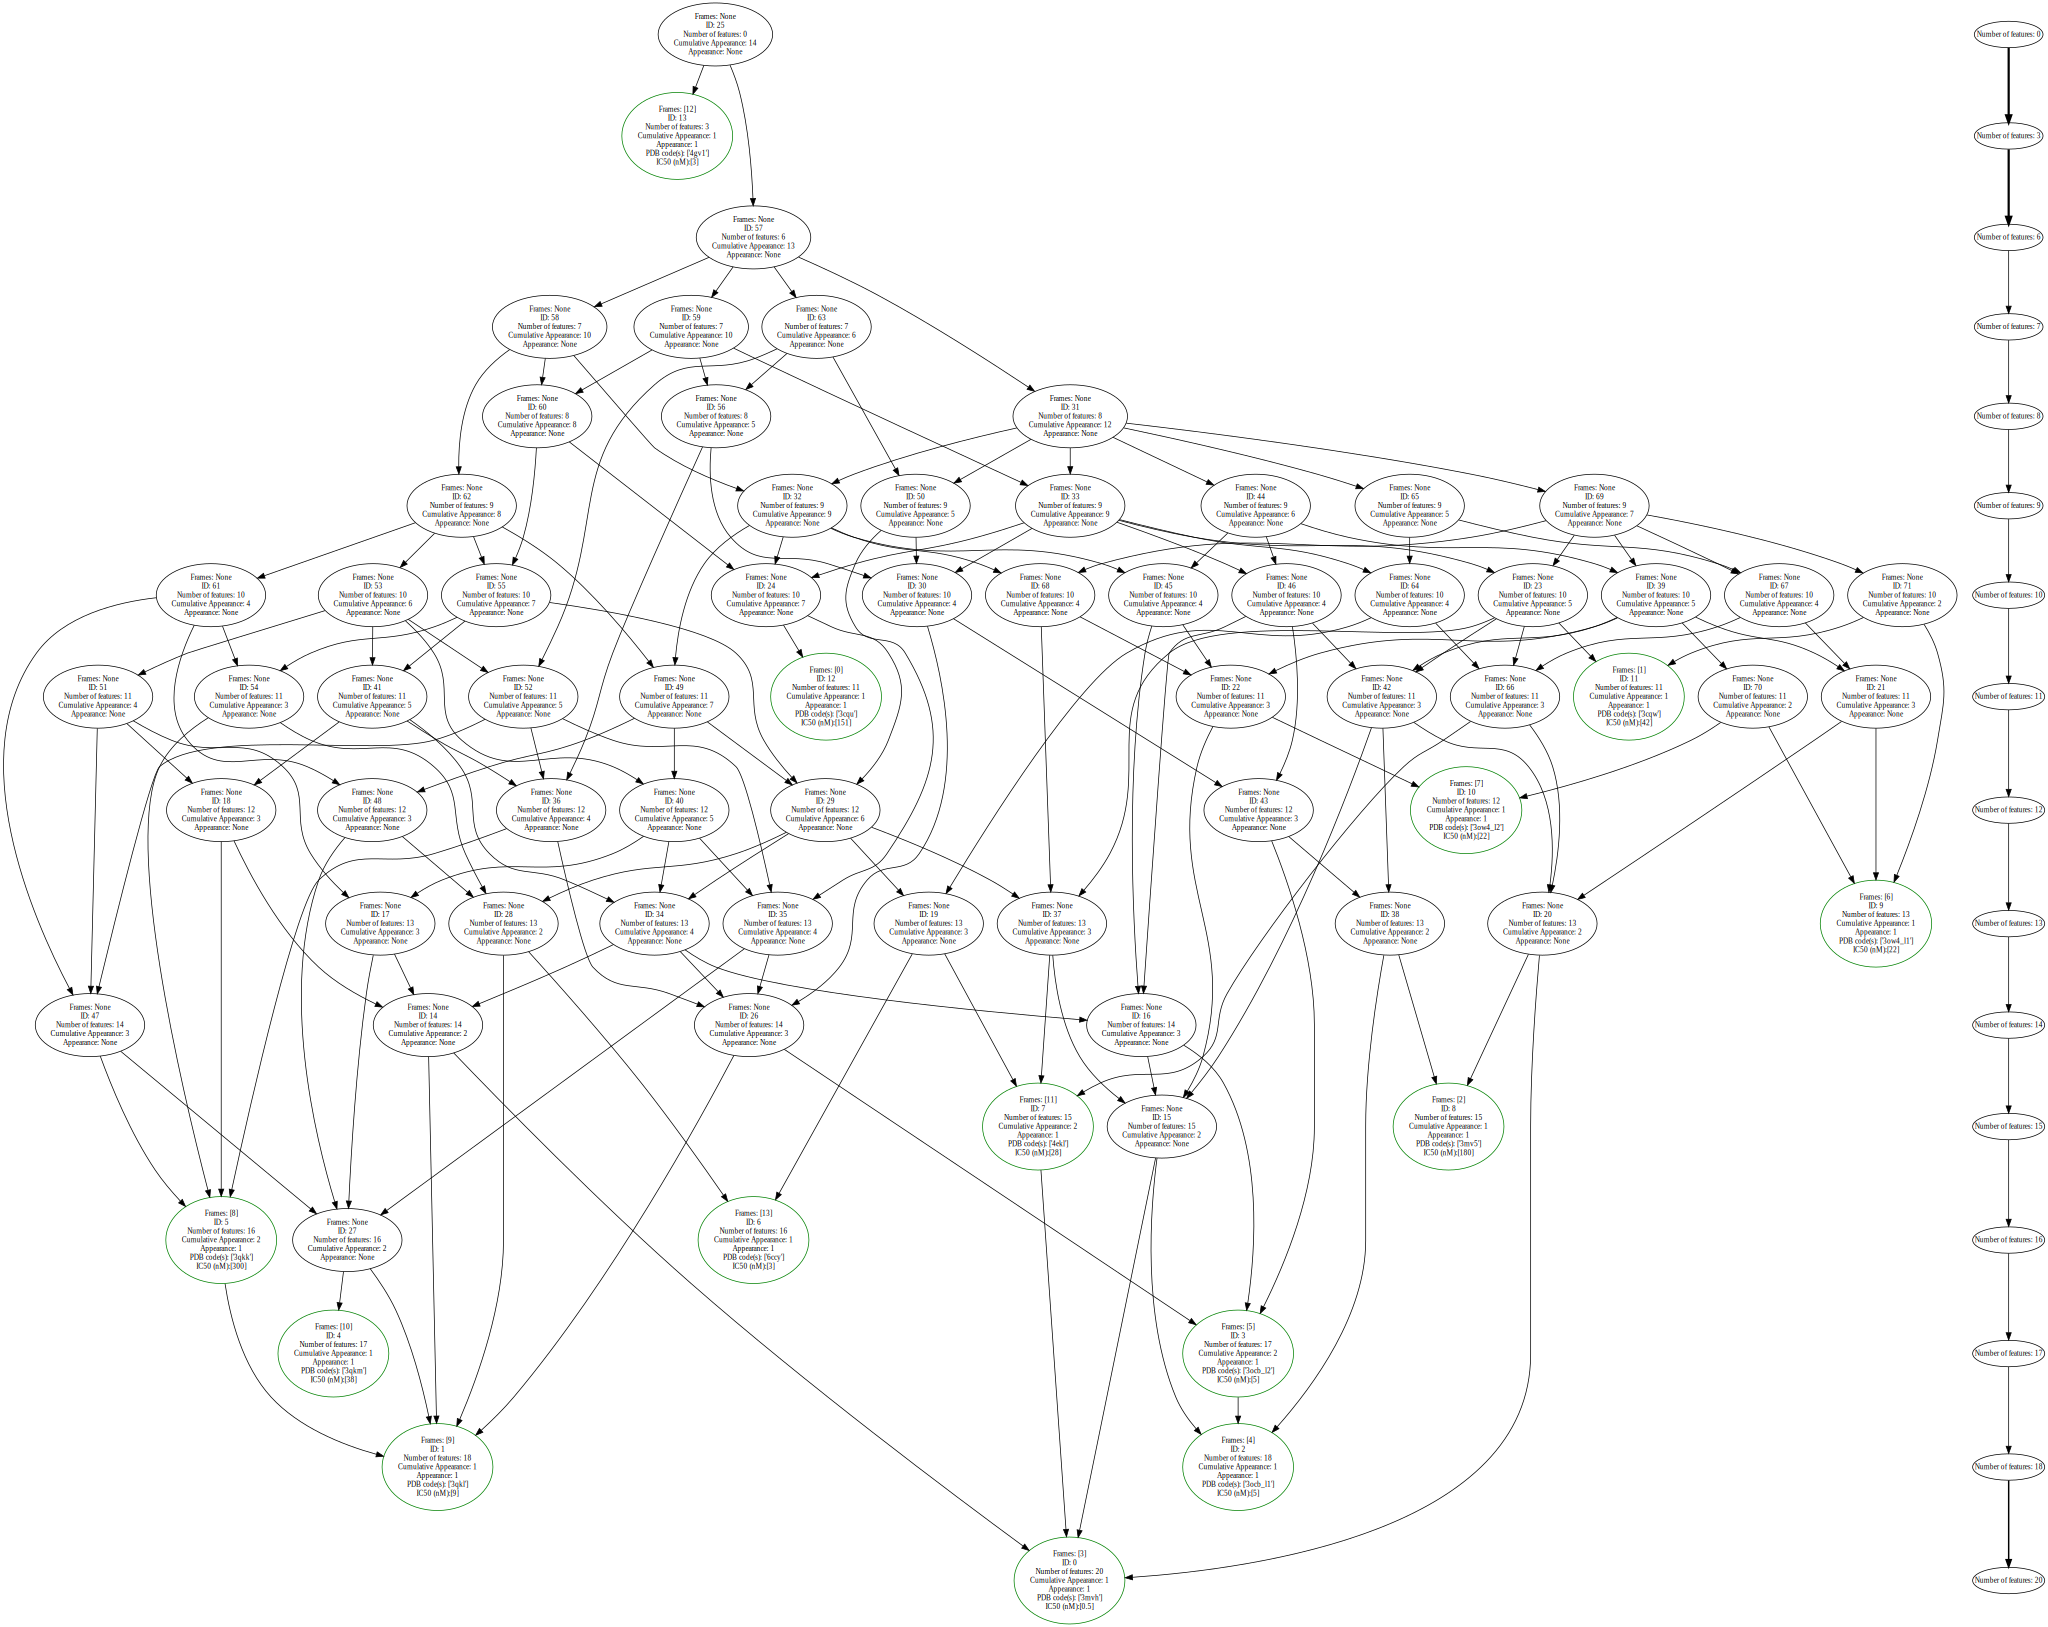

In [95]:
from IPython.display import SVG, display


A.draw('tmp_akt1.svg', prog='dot')
SVG('tmp_akt1.svg')

In [479]:
raw = [math.sqrt(math.sqrt(math.sqrt(math.sqrt(math.sqrt(math.sqrt(float(x))))))) for x in affinity.values()]
raw = [math.log(float(x)) for x in affinity.values()]

max_affinity = max(raw)
min_affinity = min(raw)
coef = [((x - max_affinity)/(min_affinity-max_affinity)) for x in raw]

coef

[0.24861378563774927,
 0.4527077499106721,
 0.38371406721544715,
 0.673372718104557,
 0.7266453496128565,
 0.9586718127723458,
 0.8878422885551057,
 0.669199058176855,
 0.9767251719585366,
 1.0,
 0.5600338953611959,
 0.17857888608383138,
 0.06332889937706661,
 -0.0]

In [424]:
def rescale(values, new_min = 0, new_max = 100):
    output = []
    old_min, old_max = min(values), max(values)

    for v in values:
        new_v = (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
        output.append(new_v)

    return output

In [509]:
tmp = [math.log(float(x)**2) for x  in affinity.values()]

In [514]:
coef = rescale(tmp, new_min=0, new_max=1)
print coef


[0.7513862143622508, 0.547292250089328, 0.6162859327845529, 0.3266272818954431, 0.2733546503871435, 0.04132818722765427, 0.11215771144489431, 0.3308009418231452, 0.023274828041463604, 0.0, 0.43996610463880415, 0.8214211139161687, 0.9366711006229335, 1.0]


In [519]:
print rescale([x for x  in affinity_scoring.values()], new_min=0, new_max=1)

[0.4918151464243269, 0.437553224082902, 0.5268668664815912, 0.7356333503684427, 0.9256982467381211, 0.6827997491649868, 0.5874642177266579, 0.5282703887945069, 0.686056424622279, 1.0, 0.5037144549786706, 0.6153477714217886, 0.06328178939154341, 0.0]


In [511]:
calculated_affinity = {}
normalized_scoring = rescale([x for x  in affinity_scoring.values()], new_min=0, new_max=1)
for key, value in affinity.items():
    calculated_affinity[key] = (value*affinity[1])/coef[1]

In [512]:
calculated_affinity

{0: 186.08031343979016,
 1: 14.9323708315881,
 2: 35.03363925872593,
 3: 0.9763473236038375,
 4: 0.505403320453751,
 5: 0.02871609775305404,
 6: 0.06891863460732969,
 7: 1.0280362995593346,
 8: 0.022972878202443234,
 9: 0.017229658651832423,
 10: 3.9628214899214567,
 11: 442.2279053970322,
 12: 1837.8302561954583,
 13: 4020.2536854275654}

In [ ]:
#coef_vector = [1,2,3,14,12,13,4,7,11,10,8,9,6,5]

In [513]:
coef_vector = [0]*len(ph4_fingerprint_dict[0])
for index, value in ph4_fingerprint_dict.items():
    tmp_coef = [(a*coef[index])/sum(value) for a in value]
    #tmp_coef = [a*coef[index] for a in value]
    coef_vector = [a+b for a,b in zip(coef_vector,tmp_coef)]
coef_vector

[0.09586718127723458,
 0.542948166712363,
 0.06666666666666667,
 0.5273357471227677,
 0.767912154390076,
 0.31671327334176436,
 0.7599960419679427,
 0.06771129481842805,
 0.22828277704571592,
 0.17169430830688193,
 0.7599960419679427,
 0.5077646761219837,
 0.528375694668744,
 0.5983799315888935,
 0.10154976368625276,
 0.06666666666666667,
 0.14818616050189823,
 0.333529420405415,
 0.051476850628988845,
 0.3797569374259421,
 0.1549008349083932,
 0.007916112422133326,
 0.051476850628988845,
 0.051476850628988845,
 0.11398370160832488,
 0.06250685097933603,
 0.3163627262774852]

In [516]:
tmp = affinity.values()
affinity_scoring = {}
for index, value in ph4_fingerprint_dict.items():
    print tmp[index]
    affinity_scoring[index] = sum([a*b for a,b in zip(coef_vector,value)])
    print sum([a*b for a,b in zip(coef_vector,value)])
    print

32.4
4.41562836664

2.6
4.21679200489

6.1
4.54407122653

0.17
5.30907118082

0.088
6.00554139159

0.005
5.11546873203

0.012
4.76612301411

0.179
4.54921426715

0.004
5.12740243197

0.003
6.27781133066

0.69
4.4592319678

77
4.86829898079

320
2.84531883976

700
2.61343024783



In [455]:
print affinity_scoring[11]
print math.exp(affinity_scoring[11])

-0.84724268108
0.428595077498


In [484]:
for x in sorted(affinity.keys(), key=lambda k: affinity[k]):
    print x
    print affinity[x]
    print affinity_scoring[x]
    print 

9
0.003
6.27781133066

8
0.004
5.12740243197

5
0.005
5.11546873203

6
0.012
4.76612301411

4
0.088
6.00554139159

3
0.17
5.30907118082

7
0.179
4.54921426715

10
0.69
4.4592319678

1
2.6
4.21679200489

2
6.1
4.54407122653

0
32.4
4.41562836664

11
77
4.86829898079

12
320
2.84531883976

13
700
2.61343024783



In [517]:
print [x for x in sorted(affinity.keys(), key=lambda k: affinity[k])]
print [x for x in sorted(affinity_scoring.keys(), key=lambda k: affinity_scoring[k], reverse=True)]

[9, 8, 5, 6, 4, 3, 7, 10, 1, 2, 0, 11, 12, 13]
[9, 4, 3, 8, 5, 11, 6, 7, 2, 10, 0, 1, 12, 13]


In [520]:
affinity_scoring

{0: 4.415628366635007,
 1: 4.216792004888924,
 2: 4.544071226533612,
 3: 5.309071180818198,
 4: 6.005541391585905,
 5: 5.115468732030299,
 6: 4.766123014105835,
 7: 4.549214267146395,
 8: 5.127402431968928,
 9: 6.277811330660076,
 10: 4.459231967800339,
 11: 4.8682989807884365,
 12: 2.8453188397610583,
 13: 2.6134302478268503}

In [701]:
def rescale(values, new_min = 0, new_max = 1):
    old_min, old_max = min(values), max(values)
    return [(new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min for v in values]

In [702]:
affinity

{0: 0.004, 1: 0.003, 2: 0.69, 3: 77, 4: 320, 5: 700}

In [709]:
tmp = [math.log(float(x)) for x  in affinity.values()]
tmp = affinity.values()
coef = rescale(tmp, new_min=1, new_max=0)
coef

[0.999998571422449,
 1.0,
 0.999018567222431,
 0.8900038143020613,
 0.542859469397726,
 0.0]

In [710]:
coef_vector = [0]*len(ph4_fingerprint_dict[0])
for index, value in ph4_fingerprint_dict.items():
    tmp_coef = [a*coef[index] for a in value]
    coef_vector = [a+b for a,b in zip(coef_vector,tmp_coef)]
coef_vector

[4.431880422344667,
 1.0,
 3.4328618551222365,
 4.431880422344667,
 1.999018567222431,
 3.8890209529469413,
 0.8900038143020613,
 2.8900023857245105,
 2.8900023857245105,
 3.8890209529469413,
 2.8900023857245105,
 1.0,
 1.999018567222431,
 1.0,
 1.0,
 1.542858040820175,
 2.99901713864488,
 3.4318804223446673,
 1.4328632836997874,
 0.542859469397726,
 0.542859469397726]

In [711]:
for index, value in enumerate(global_ph4_interaction_list):
    coef_vector[index] = coef_vector[index]/value[1]
coef_vector

[0.7386467370574445,
 1.0,
 0.8582154637805591,
 0.7386467370574445,
 0.9995092836112155,
 0.7778041905893882,
 0.8900038143020613,
 0.9633341285748368,
 0.9633341285748368,
 0.9722552382367353,
 0.9633341285748368,
 1.0,
 0.9995092836112155,
 1.0,
 1.0,
 0.7714290204100875,
 0.9996723795482932,
 0.6863760844689335,
 0.4776210945665958,
 0.271429734698863,
 0.542859469397726]

In [712]:
affinity_scoring = {}
for index, value in ph4_fingerprint_dict.items():
    affinity_scoring[index] = sum([a*b for a,b in zip(coef_vector,value)])
affinity_scoring

{0: 9.433048236873397,
 1: 13.974261699216807,
 2: 6.9124199341806705,
 3: 9.029571745783672,
 4: 5.0852243414376535,
 5: 3.6905245784386698}

In [713]:
coef

[0.999998571422449,
 1.0,
 0.999018567222431,
 0.8900038143020613,
 0.542859469397726,
 0.0]

In [714]:
print [x for x in sorted(affinity.keys(), key=lambda k: affinity[k])]
print [x for x in sorted(affinity_scoring.keys(), key=lambda k: affinity_scoring[k], reverse=True)]

[1, 0, 2, 3, 4, 5]
[1, 0, 3, 2, 4, 5]


In [715]:
calculated_affinity = {}
normalized_scoring = rescale([x for x  in affinity_scoring.values()], new_min=0, new_max=1)
print normalized_scoring
for key, value in affinity.items():
    calculated_affinity[key] = (normalized_scoring[key]*affinity[1])/coef[1]

[0.5584082509102691, 1.0, 0.3133000501570785, 0.5191738280199265, 0.13562188012186868, 0.0]


In [716]:
[(x,affinity[x],calculated_affinity[x]) for x in sorted(affinity.keys(), key=lambda k: affinity[k])]

[(1, 0.003, 0.003),
 (0, 0.004, 0.0016752247527308075),
 (2, 0.69, 0.0009399001504712355),
 (3, 77, 0.0015575214840597795),
 (4, 320, 0.00040686564036560604),
 (5, 700, 0.0)]

In [616]:
tmp

[3.4781584227982836,
 0.9555114450274363,
 1.8082887711792655,
 -1.7719568419318752,
 -2.430418464503931,
 -5.298317366548036,
 -4.422848629194137,
 -1.720369473141382,
 -5.521460917862246,
 -5.809142990314028,
 -0.37106368139083207,
 4.343805421853684,
 5.768320995793772,
 6.551080335043404]

In [46]:
global_ph4_interaction_list

[(<__main__.Ph4InteractionInformation at 0x7f176254fbd0>, 1),
 (<__main__.Ph4InteractionInformation at 0x7f1764244710>, 1),
 (<__main__.Ph4InteractionInformation at 0x7f1764247fd0>, 2),
 (<__main__.Ph4InteractionInformation at 0x7f176254f590>, 12),
 (<__main__.Ph4InteractionInformation at 0x7f17642a7dd0>, 4),
 (<__main__.Ph4InteractionInformation at 0x7f176254f450>, 10),
 (<__main__.Ph4InteractionInformation at 0x7f17642a7e50>, 8),
 (<__main__.Ph4InteractionInformation at 0x7f1762616190>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f176254f110>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f17625dcdd0>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f17642a7c90>, 8),
 (<__main__.Ph4InteractionInformation at 0x7f176254f210>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f1764244a10>, 2),
 (<__main__.Ph4InteractionInformation at 0x7f176254f1d0>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f176254f350>, 13),
 (<__main__.Ph4InteractionInformation at 0x7f17641de510>, 5),


In [53]:

len(main_pool)

72

In [114]:
list_inter = []
ind = 0
for index, val in enumerate(main_pool[ind].fingerprint):
    if val == 1 and main_pool[14].fingerprint[index] == 0:
        print index
        list_inter.append(index)
        
for x in list_inter:
    print global_ph4_interaction_list[x][0]

1
12
15
25
28
32
> env_atom            : ['N:589']           
> env_residue         : LYS_179_A           
> interaction_type    : AR-PI               
> lig_atom            : ['C:5363', 'C:5364', 'C:5365', 'C:5366', 'C:5368', 'C:5369']
> lig_residue         : WFE_999_A           

> env_atom            : ['C:1427']          
> env_residue         : TYR_229_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5349', 'N:5350', 'C:5351', 'N:5352', 'C:5353', 'C:5372']
> lig_residue         : WFE_999_A           

> env_atom            : ['C:4817', 'C:4818', 'C:4819', 'C:4820', 'C:4821', 'C:4822']
> env_residue         : PHE_438_A           
> interaction_type    : H-H                 
> lig_atom            : ['C:5324', 'C:5325', 'C:5326', 'N:5327', 'C:5328']
> lig_residue         : XFE_999_A           

> env_atom            : ['O:1581']          
> env_residue         : GLU_234_A           
> interaction_type    : HBD-HBA             
> lig_atom          

In [97]:
len(list_inter)

18

In [111]:
for index, val in enumerate(main_pool):
    if val.fingerprint[3] == 1 and val.frames != None:
        print index

0
1
2
3
4
6
7
8
9
10
11
12
